# **Spam Detection using LSTMs**
In this notebook, I will use basic LSTMs to classify SMSs as spam or ham using various text processing objects like `Tokenizer`, `Embedding`, and `pad_sequences`.

## **Importing Relevant Libraries**

In [1]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model

## **Uploading data from Kaggle**

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "sushrutgaikwad"
os.environ['KAGGLE_KEY'] = "7d35f99822daf68b0a5cc2bc4756f94e"
! kaggle datasets download uciml/sms-spam-collection-dataset

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 65.7MB/s]


In [3]:
! unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


## **Processing the data**

In [4]:
data = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


We can see that we have got three unnecessary columns. Let's delete them and rename the existing columns to something meaningful.

In [7]:
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
data.columns = ['label', 'text']

In [8]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Now, the labels are the strings `'ham'`, and `'spam'`. But in tensorflow, we want the labels to have a binary encoding, say $0$ and $1$. To do this, I create a new column consisting these binary labels. We create these binary labels by mapping a dictionary, as shown below. The column containing these binary variables would be our target which we want to predict.

In [9]:
data['binary_label'] = data['label'].map({'ham': 0, 'spam': 1})

In [10]:
data.head()

,label,text,binary_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Let's now label the predictor as `X`, and the target as `y`.

In [11]:
X = data['text'].values
y = data['binary_label'].values

#### **Splitting the data into the training set and the test set**
Let's now split the data into training set and the test set. We do this using the `train_test_split` object, which we have imported from scikit-learn.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### **Text processing**
Let's now convert the sentences in the `text` column into sequences of integers. We do this using the `Tokenizer` object.

In [13]:
MAX_VOCAB_SIZE = 20000 # This is the maximum number of words we can have in our vocabulary
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

We fit this `tokenizer` to the training set, and transform the training and the test set. We do this to avoid information leakage from the training set into the test set.

In [14]:
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

Now, let's check the word to index mapping to see how many words we have in our vocabulary

In [15]:
word_to_index_mapping = tokenizer.word_index
V = len(word_to_index_mapping)
print(f'We have a total of {V} unique tokens.')

We have a total of 7386 unique tokens.


This is much less than the $20,000$ we provided earlier in `MAX_VOCAB_SIZE`.

Now, our sequences have variable lengths, and tensorflow only accepts constant sized sequences. For this, we pad our sequences to the length of the largest sequence. We do this in the following way using the `pad_sequences` object.

In [16]:
data_train = pad_sequences(sequences_train)
print(f'Shape of data_train tensor: {data_train.shape}')

# We also capture the sequence length in the following variable
T = data_train.shape[1]

Shape of data_train tensor: (3900, 189)


As expected, this is an $N\times T$ array, where $N$ is the number of samples, and $T$ is the number of time steps. Hence, we set the value of the variable `T` as the length of the second dimension of `data_train`, as shown above.

Now, we pad the test set.

In [17]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f'Shape of data_test tensor: {data_test.shape}')

Shape of data_test tensor: (1672, 189)


Here, while padding the test set, we gave `maxlen = T` because ideally we won't have the test set. So, if the test set contains longer sentences than the training set, they will be truncated to `T`. This is to mimic how we will do it in a live environment since we don't have access to the test set.

## **Constructing the model**

In [18]:
# First we choose the dimensionality of the Embedding
D = 20

# Next, we set the hidden state dimensionality
M = 15

# Now, we define the layers of our model
i = Input(shape=(T,))
# Our input are sequences of integers which we prepared by applying `tokenizer`
# to our training and test sets. Hence the shape is `T`

x = Embedding(V + 1, D)(i)
# The embedding layer takes in the above sequences of integers and returns
# sequences of word vectors. This would be an N x T x D array, which is how
# the usual RNN expects its input to be.

x = LSTM(M, return_sequences=True)(x)
# This is were the RNN begins. We set `return_sequences = True` to apply
# global max pooling next.

x = GlobalMaxPooling1D()(x)

x = Dense(1, activation='sigmoid')(x)
# As spam detection is a binary classification, we have only a single dense
# unit, and the activation is sigmoid

model = Model(i, x)

Note that I have sized the embedding above to be $(V+1)\times D$ because here the first index starts from $1$, and not $0$.

### **Compiling and fitting the model**

In [19]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Obviously, loss is 'binary_crossentropy' because this is a binary
# classification

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           verbose=1,
                           mode='auto')

r = model.fit(
    data_train,
    y_train,
    epochs=12,
    validation_data=(data_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/12
122/122 [==============================] - 12s 80ms/step - loss: 0.4624 - accuracy: 0.8662 - val_loss: 0.3931 - val_accuracy: 0.8654
Epoch 2/12
122/122 [==============================] - 9s 76ms/step - loss: 0.3854 - accuracy: 0.8662 - val_loss: 0.3731 - val_accuracy: 0.8654
Epoch 3/12
122/122 [==============================] - 9s 76ms/step - loss: 0.3347 - accuracy: 0.8662 - val_loss: 0.2809 - val_accuracy: 0.8654
Epoch 4/12
122/122 [==============================] - 9s 76ms/step - loss: 0.1896 - accuracy: 0.9208 - val_loss: 0.1403 - val_accuracy: 0.9791
Epoch 5/12
122/122 [==============================] - 9s 76ms/step - loss: 0.0768 - accuracy: 0.9877 - val_loss: 0.0798 - val_accuracy: 0.9821
Epoch 6/12
122/122 [==============================] - 9s 76ms/step - loss: 0.0401 - accuracy: 0.9936 - val_loss: 0.0644 - val_accuracy: 0.9839
Epoch 7/12
122/122 [==============================] - 9s 77ms/step - loss: 0.0252 - accuracy: 0.9954 - val_loss: 0.0594 - val_accuracy: 0.983

### **Plotting the loss and accuracy**

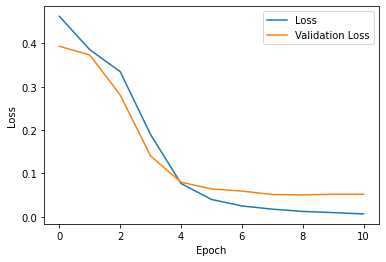

In [22]:
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

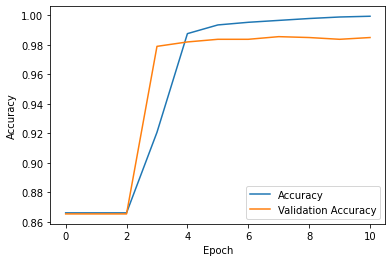

In [23]:
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()